In [4]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp, ttest_rel, sem, t, zscore, chi2_contingency, fisher_exact
import pingouin as pg


In [5]:
def align_x_position(x_list):
    if not x_list:  # Handle empty lists if needed
        return x_list
    shift_amount = x_list[0] - 960  # Calculate shift
    return [x - shift_amount for x in x_list] 

def flip_y_pos(y_list):
    return [-y for y in y_list] 

# auf 0,0 normalisieren jeden trial
def normalize_positions(row): 
    x_positions = row["xpos"]
    y_positions = row["ypos"]
    
    x_start, y_start = x_positions[0], y_positions[0]

    row["xpos"] = [x - x_start for x in x_positions]
    row["ypos"] = [y - y_start for y in y_positions]
    
    return row

# Interpolation auf 100 Zeiteinheiten
def interpolate_positions(row):
    original_length = len(row["xpos"])
    original_time = np.linspace(0, 1, original_length)  # Ursprünglicher Zeitvektor
    new_time = np.linspace(0, 1, 100)  # Ziel-Zeitvektor mit 100 Zeiteinheiten
    
    # Interpolation der x- und y-Positionen
    row["xpos"] = np.interp(new_time, original_time, row["xpos"])
    row["ypos"] = np.interp(new_time, original_time, row["ypos"])
    return row

def can_convert_to_int(lst):
    """Checks if every value in a list can be converted to an integer."""
    if not isinstance(lst, list):  
        return False  # Ensure input is a list
    
    try:
        return all(isinstance(int(x), int) for x in lst)  # Try converting each element
    except (ValueError, TypeError):  
        return False  # If any element fails, return False

In [6]:
directory = "data"
mouse_data_regex = r"mouse_data_(\d+)"
grouped_data = []

for filename in os.listdir(directory):
    mouse_data_match = re.search(mouse_data_regex, filename)

    if mouse_data_match:
        participant_num = int(mouse_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_mouse_data =  pd.read_csv(file_path, sep=",")
        grouped_mouse_data = df_mouse_data.groupby(["blocknumber", "trialnumber"]).agg({
            "timedifference": list,  
            "xpos": list,            
            "ypos": list             
        }).reset_index()    

        grouped_mouse_data["xpos"] = grouped_mouse_data["xpos"].apply(align_x_position)

        grouped_mouse_data["ypos"] = grouped_mouse_data["ypos"].apply(flip_y_pos)
        
        grouped_mouse_data = grouped_mouse_data.apply(normalize_positions, axis=1)

        grouped_mouse_data = grouped_mouse_data.apply(interpolate_positions, axis=1)

        grouped_mouse_data["participant_num"] = participant_num

        grouped_data.append(grouped_mouse_data)
        #print(grouped_mouse_data["participant_num"])
        
        #print(len(grouped_mouse_data["xpos"]))
        #print(df_mouse_data.groupby("blocknumber")["trialnumber"].nunique())

        #print(df_mouse_data["blocknumber"].nunique(), df_mouse_data["trialnumber"].nunique())
        #print(df_mouse_data.groupby(["blocknumber", "trialnumber"]).size().unstack())

grouped_data[0]["ypos"]


0       [0.0, 14.86868686868687, 36.60606060606061, 55...
1       [0.0, 6.363636363636364, 15.181818181818183, 2...
2       [0.0, 10.282828282828284, 24.484848484848488, ...
3       [0.0, 0.9595959595959597, 1.9191919191919193, ...
4       [0.0, 7.757575757575758, 16.454545454545457, 2...
                              ...                        
1243    [0.0, 10.909090909090908, 25.81818181818182, 4...
1244    [0.0, 5.666666666666667, 11.484848484848486, 1...
1245    [0.0, 3.7575757575757573, 8.393939393939394, 1...
1246    [0.0, 5.6565656565656575, 11.444444444444446, ...
1247    [0.0, 5.93939393939394, 11.878787878787879, 17...
Name: ypos, Length: 1248, dtype: object

## Für manche Trials wurden keine Messwerte aufgezeichnet aus irgendeinem grund... also sind die unterschiedlich lang die grouped_mouse_data
### Wir müssen die die nicht aufgezeichnet wurden als "fail" btrachten eigentlich und rauslöschen.. (macht aber eigentlich nix) -> Sonderfall für 6 noch beachten!!!

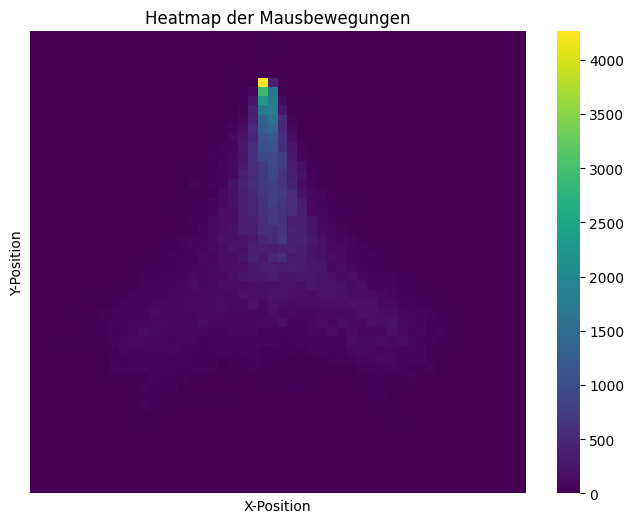

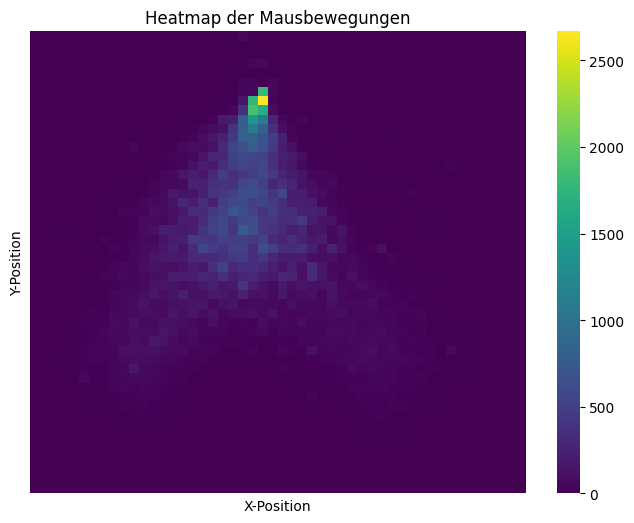

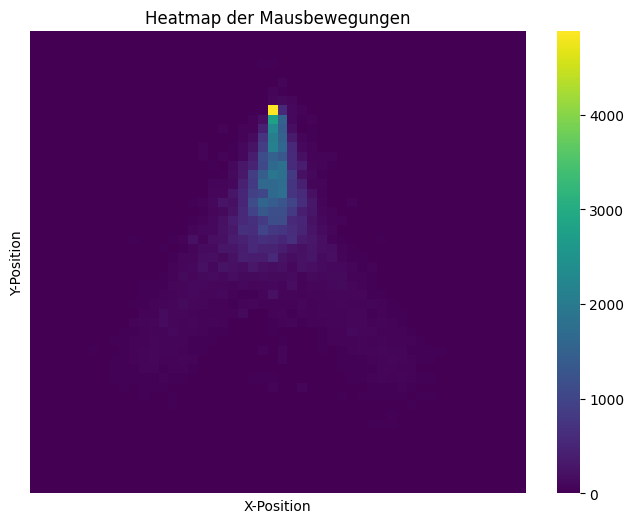

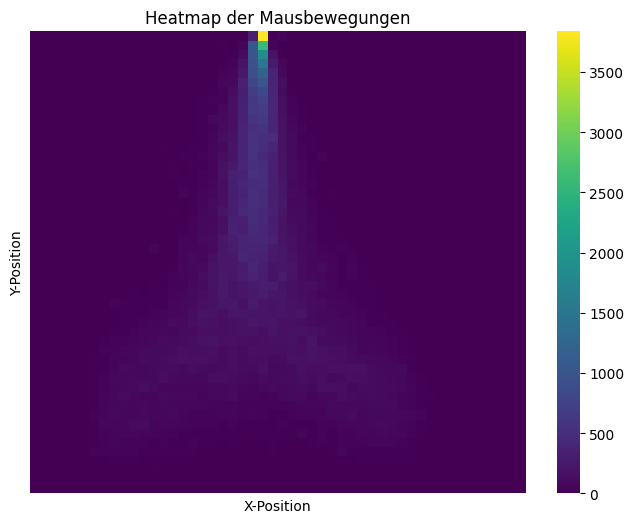

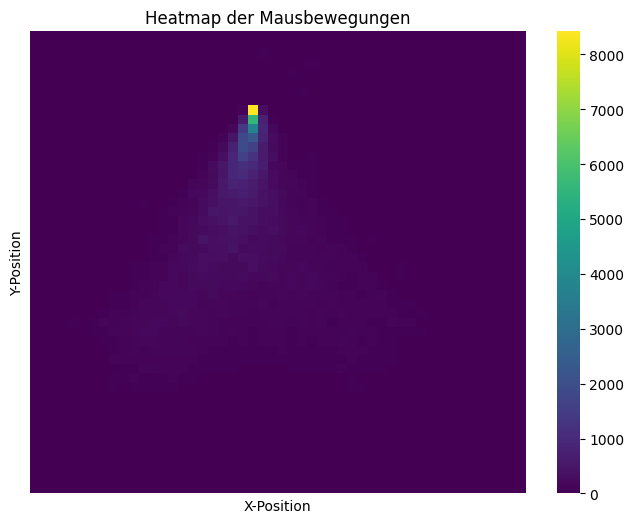

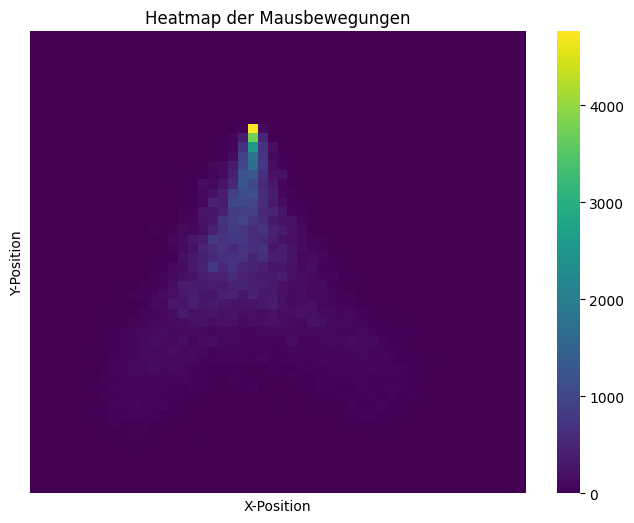

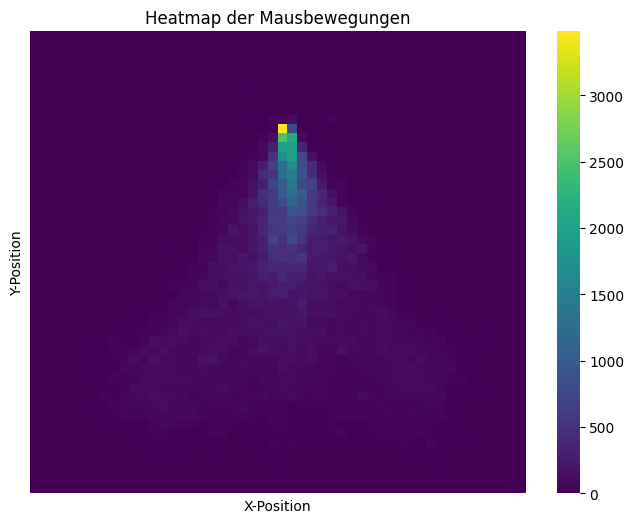

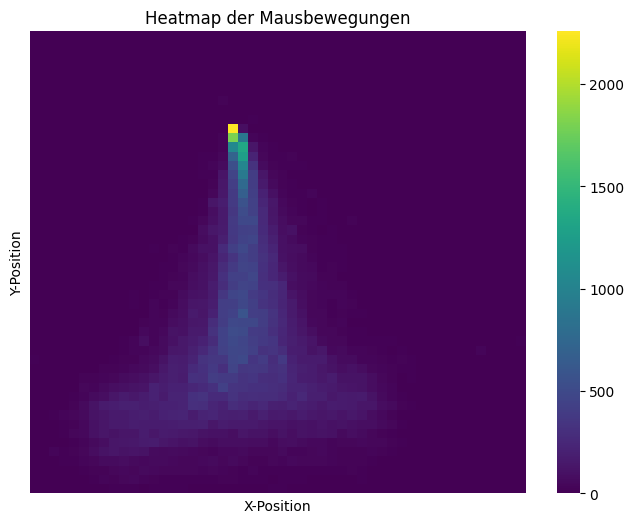

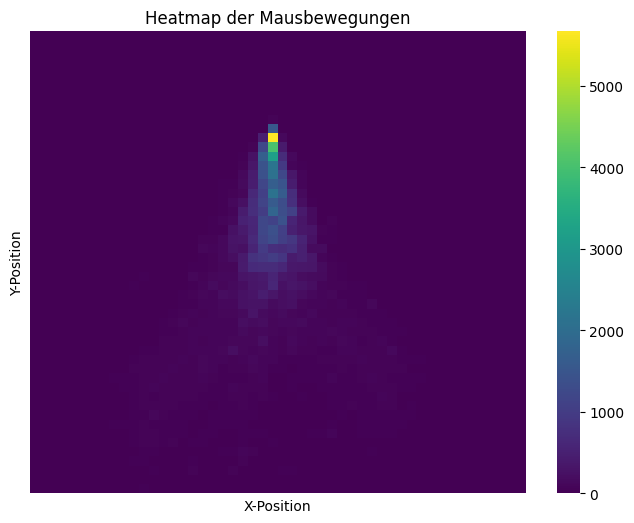

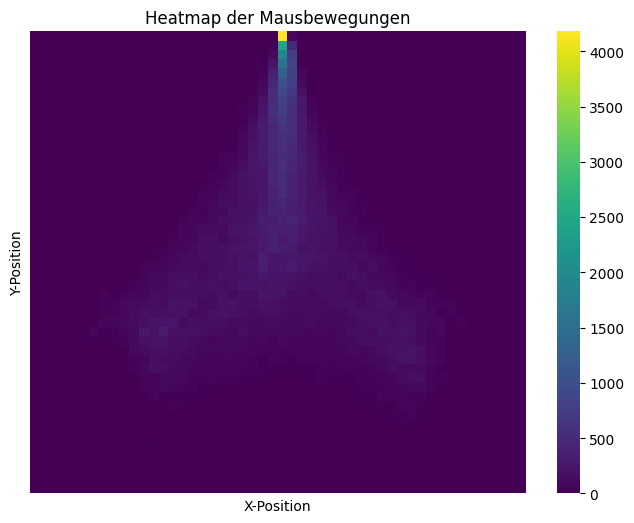

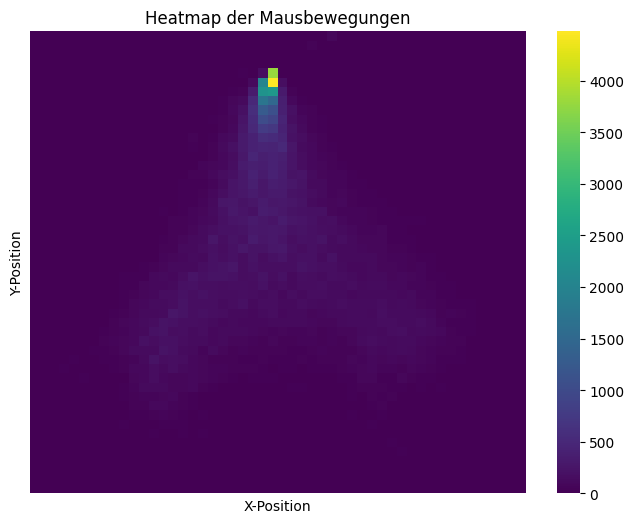

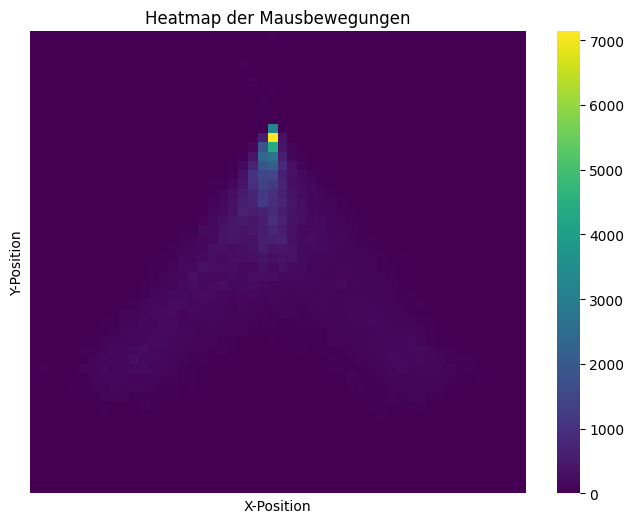

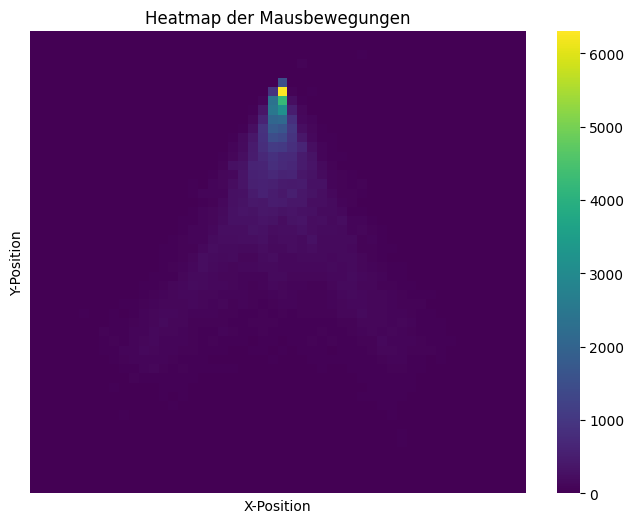

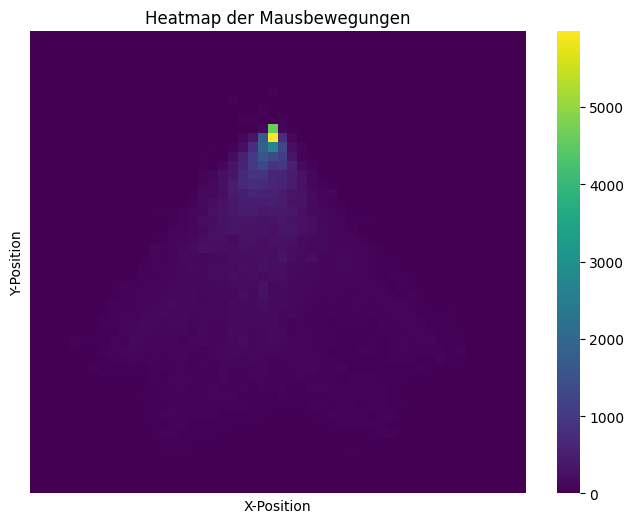

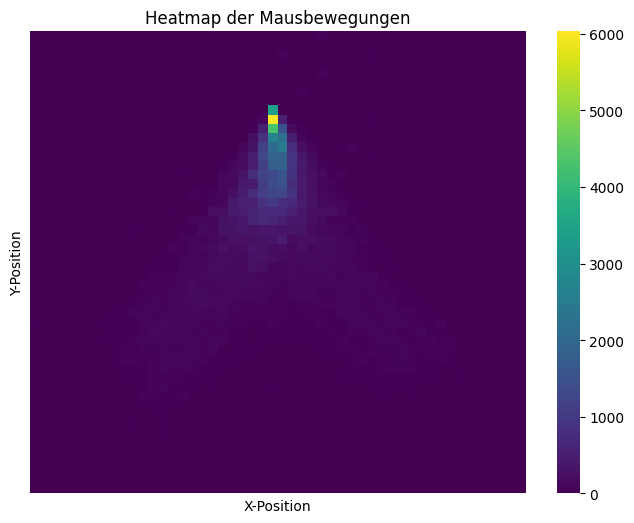

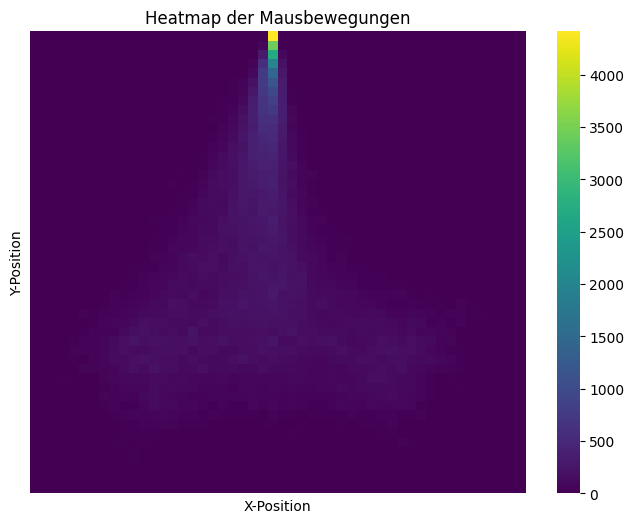

In [7]:
for grouped_mouse_data in grouped_data:
    all_xpos = [x for trial in grouped_mouse_data["xpos"] for x in trial]
    all_ypos = [y for trial in grouped_mouse_data["ypos"] for y in trial]

    # 2D-Histogramm erstellen (Heatmap-Daten)
    heatmap_data, x_edges, y_edges = np.histogram2d(
        all_xpos, all_ypos, bins=50  # 50x50 Raster
    )

    # Heatmap darstellen
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data.T,  # Transponieren, da np.histogram2d die Achsen vertauscht
        cmap="viridis",  # Farbpalette (z. B. 'viridis', 'plasma', 'coolwarm')
        xticklabels=False, yticklabels=False  # Achsenbeschriftung entfernen
    )
    plt.title("Heatmap der Mausbewegungen")
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.show()

In [8]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13, 15] 


condition_0_data_mouse = []
condition_1_data_mouse = []

for grouped_mouse_data in grouped_data:
    if grouped_mouse_data['participant_num'].iloc[0] in condition_0_participants:
        condition_0_data_mouse.append(grouped_mouse_data)
    else:
        condition_1_data_mouse.append(grouped_mouse_data)
print(len(condition_0_data_mouse)) # sind 8 weil der 6er ja zweimal da is
print(len(condition_1_data_mouse))

8
8


In [9]:
directory = "data"

trial_data_regex = r"trial_data_(\d+)"

all_trial_data = []

for filename in os.listdir(directory):
    trial_data_match = re.search(trial_data_regex, filename)

    if trial_data_match:
        participant_num = int(trial_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_trial_data = pd.read_csv(file_path, sep=",")

        # fix congruency
        df_trial_data["currentcongruency"] = (df_trial_data["currentdirection"] == df_trial_data["currentlocation"]).astype(int)
        df_trial_data["previouscongruency"] = (df_trial_data["previousdirection"] == df_trial_data["previouslocation"]).astype(int)

        df_trial_data["participant_num"] = participant_num

        all_trial_data.append(df_trial_data)
        # print(all_trial_data)

In [10]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13, 15] 

condition_0_data_trial = []
condition_1_data_trial = []

for df in all_trial_data:
    participant_num = df["participant_num"].iloc[0]
    
    if participant_num in condition_0_participants:
        condition_0_data_trial.append(df)
    else:
        condition_1_data_trial.append(df)

print(len(condition_0_data_trial))
print(len(condition_1_data_trial))

8
8


In [11]:
condition_0_with_latency = []
condition_0_no_latency = []

for trial_list in condition_0_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    no_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency.append(with_latency)
    condition_0_no_latency.append(no_latency)


In [12]:
condition_1_with_latency = []
condition_1_no_latency = []

for trial_list in condition_1_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    no_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency.append(with_latency)
    condition_1_no_latency.append(no_latency)

In [13]:
# Wieder zusammengefügt und nach latenz condition gesplittet!
combined_trial_data_with_latency = condition_0_with_latency + condition_1_with_latency
combined_trial_data_no_latency = condition_0_no_latency + condition_1_no_latency

In [14]:
len(combined_trial_data_with_latency[0])

642

In [15]:
condition_0_with_latency_mouse = []
condition_0_no_latency_mouse = []

for mouse_df in condition_0_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency_mouse.append(with_latency)
    condition_0_no_latency_mouse.append(no_latency)


condition_1_with_latency_mouse = []
condition_1_no_latency_mouse = []

for mouse_df in condition_1_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency_mouse.append(with_latency)
    condition_1_no_latency_mouse.append(no_latency)

combined_with_latency_mouse = condition_0_with_latency_mouse + condition_1_with_latency_mouse
combined_no_latency_mouse = condition_0_no_latency_mouse + condition_1_no_latency_mouse

In [16]:
print(len(combined_no_latency_mouse[0]))

640


In [17]:
combined_with_latency_df = pd.concat(combined_trial_data_with_latency, ignore_index=True)
combined_with_latency_mouse_df = pd.concat(combined_with_latency_mouse, ignore_index=True)

combined_with_latency_final = pd.merge(
    combined_with_latency_df,       
    combined_with_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(combined_with_latency_final.columns)

Index(['trialnumber', 'blocknumber', 'success', 'reactiontime',
       'currentcongruency', 'currentdirection', 'currentlocation',
       'previouscongruency', 'previousdirection', 'previouslocation',
       'participant_num', 'timedifference', 'xpos', 'ypos'],
      dtype='object')


In [18]:
print(combined_with_latency_final.iloc[0])

trialnumber                                                           4
blocknumber                                                           1
success                                                               1
reactiontime                                                        462
currentcongruency                                                     0
currentdirection                                                      1
currentlocation                                                       0
previouscongruency                                                    1
previousdirection                                                     0
previouslocation                                                      0
participant_num                                                       1
timedifference        [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...
xpos                  [0.0, -1.8585858585858588, -7.151515151515152,...
ypos                  [0.0, 14.86868686868687, 36.60606060606061

In [19]:
combined_no_latency_df = pd.concat(combined_trial_data_no_latency, ignore_index=True)
combined_no_latency_mouse_df = pd.concat(combined_no_latency_mouse, ignore_index=True)

combined_no_latency_final = pd.merge(
    combined_no_latency_df,       
    combined_no_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(len(combined_no_latency_final))

10245


### Vergleich zwischen Error-Rates

In [20]:
def detailed_success_rate_comparison(df1, df2):

    def validate_success_column(df, name):
        unique_values = df['success'].unique()
        if not set(unique_values).issubset({0, 1}):
            raise ValueError(f"{name} 'success' column must contain only 0 and 1. Found: {unique_values}")
    
    validate_success_column(df1, "First dataframe")
    validate_success_column(df2, "Second dataframe")
    
    # Calculate success rates
    def get_success_counts(df):
        success_counts = df['success'].value_counts()
        total = len(df)
        return {
            'success_count': success_counts.get(1, 0),
            'failure_count': success_counts.get(0, 0),
            'total': total,
            'success_rate': success_counts.get(1, 0) / total * 100
        }
    
    group1_stats = get_success_counts(df1)
    group2_stats = get_success_counts(df2)
    
    # Create contingency table
    contingency_table = np.array([
        [group1_stats['failure_count'], group1_stats['success_count']],
        [group2_stats['failure_count'], group2_stats['success_count']]
    ])
    
    # Perform Fisher's exact test with more robust method
    _, p_value = fisher_exact(contingency_table, alternative='two-sided')
    
    # Interpret results
    significance_level = 0.05
    is_significant = p_value < significance_level
    
    return {
        'group1_stats': group1_stats,
        'group2_stats': group2_stats,
        'contingency_table': contingency_table,
        'p_value': p_value,
        'is_significant': is_significant,
        'interpretation': (
            "There is a statistically significant difference in success rates" 
            if is_significant 
            else "No statistically significant difference in success rates"
        ),
        'detailed_interpretation': f"""
Detailed Analysis:
- Group 1 Success Rate: {group1_stats['success_rate']:.2f}% ({group1_stats['success_count']}/{group1_stats['total']})
- Group 2 Success Rate: {group2_stats['success_rate']:.2f}% ({group2_stats['success_count']}/{group2_stats['total']})
- p-value: {p_value:.6f}
- Significant at 0.05 level: {is_significant}
"""
    }

In [21]:
er_results = detailed_success_rate_comparison(combined_with_latency_final, combined_no_latency_final)

print(er_results["detailed_interpretation"])


Detailed Analysis:
- Group 1 Success Rate: 95.94% (9790/10204)
- Group 2 Success Rate: 97.15% (9953/10245)
- p-value: 0.000002
- Significant at 0.05 level: True



## Preprocessing

### Fehlerhafte Trials ausschließen

In [22]:
combined_with_latency_final["remove"] = combined_with_latency_final["success"] == 0
combined_with_latency_final["remove"] = combined_with_latency_final["remove"] | combined_with_latency_final["remove"].shift(1, fill_value=0)
combined_with_latency_final_errors = combined_with_latency_final[~combined_with_latency_final["remove"]].drop(columns=["remove"])

print(f"Mit Latenz: Es wurden {len(combined_with_latency_final) -  len(combined_with_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_with_latency_final)} entfernt")

Mit Latenz: Es wurden 809 fehlerhafte Trials von insgesamt 10204 entfernt


In [23]:
combined_no_latency_final["remove"] = combined_no_latency_final["success"] == 0
combined_no_latency_final["remove"] = combined_no_latency_final["remove"] | combined_no_latency_final["remove"].shift(1, fill_value=0)
combined_no_latency_final_errors = combined_no_latency_final[~combined_no_latency_final["remove"]].drop(columns=["remove"])


print(f"Ohne Latenz: Es wurden {len(combined_no_latency_final) -  len(combined_no_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_no_latency_final)} entfernt")

Ohne Latenz: Es wurden 576 fehlerhafte Trials von insgesamt 10245 entfernt


### Ausschluss extremer Reaktionszeiten

In [24]:
averageReactiontimeWithLatency = combined_with_latency_final_errors["reactiontime"].mean()
averageReactiontimeNoLatency = combined_no_latency_final_errors["reactiontime"].mean()

print(f"Durchschnittszeit in Trials mit Latenz: {averageReactiontimeWithLatency}")
print(f"Durchschnittszeit in Trials ohne Latenz: {averageReactiontimeNoLatency}")

Durchschnittszeit in Trials mit Latenz: 498.9469930814263
Durchschnittszeit in Trials ohne Latenz: 441.65715172199816


In [25]:
mean_rt_with_latency = combined_with_latency_final_errors["reactiontime"].mean()
std_rt_with_latency = combined_with_latency_final_errors["reactiontime"].std()

combined_with_latency_final_errors["outlier"] = (combined_with_latency_final_errors["reactiontime"] < mean_rt_with_latency - 4 * std_rt_with_latency) | (combined_with_latency_final_errors["reactiontime"] > mean_rt_with_latency + 4 * std_rt_with_latency)

combined_with_latency_final_outliers = combined_with_latency_final_errors[~combined_with_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Mit Latenz: Von {len(combined_with_latency_final_errors)} wurden {len(combined_with_latency_final_errors) - len(combined_with_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Mit Latenz: Von 9395 wurden 76 Trials aufgrund von zu hoher Standardabweichung entfernt.


In [26]:
mean_rt_no_latency = combined_no_latency_final_errors["reactiontime"].mean()
std_rt_no_latency = combined_no_latency_final_errors["reactiontime"].std()

combined_no_latency_final_errors["outlier"] = (combined_no_latency_final_errors["reactiontime"] < mean_rt_no_latency - 4 * std_rt_no_latency) | (combined_no_latency_final_errors["reactiontime"] > mean_rt_no_latency + 4 * std_rt_no_latency)

combined_no_latency_final_outliers = combined_no_latency_final_errors[~combined_no_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Ohne Latenz: Von {len(combined_no_latency_final_errors)} wurden {len(combined_no_latency_final_errors) - len(combined_no_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Ohne Latenz: Von 9669 wurden 59 Trials aufgrund von zu hoher Standardabweichung entfernt.


In [27]:
combined_no_latency_final_outliers["latency"] = 1
combined_with_latency_final_outliers["latency"] = 0

In [28]:
combined_no_latency_final_outliers.to_pickle("preprocessed_data/preprocessed_no_latency.pkl")
combined_with_latency_final_outliers.to_pickle("preprocessed_data/preprocessed_with_latency.pkl")